In [1]:
import pandas as pd
import numpy as np
import nba_api.stats.endpoints as nba
import nba_api.stats.static.players as players
import nba_api.stats.static.teams as teams
import networkx as nx
import random
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Helper functions
def return_id_by_nickname(nickname):
    return teams.find_teams_by_nickname(nickname)[0]['id']
def return_nickname_by_id(id):
    return teams.find_team_name_by_id(id)['nickname']
def return_player_name_by_id(id):
    return players.find_player_by_id(id)['full_name']

# These are crazy slow for big dfs
def add_full_name_column(df):
    df['full_name'] = df['PLAYER_ID'].apply(return_player_name_by_id)
    return df
def add_nickname_column(df):
    df['TEAM_NICKNAME'] = df['TEAM_ID'].apply(return_nickname_by_id)
    return df
def add_pass_to_column(df):
    df['PASS_TO'] = df['PASS_TEAMMATE_PLAYER_ID'].apply(return_player_name_by_id)

In [3]:
df = pd.read_csv('data/active_player_info_team.csv')
df

,index,id,Full_name,Firstname,Surname,Active,team_name,team_id
0,0,1630173,Precious Achiuwa,Precious,Achiuwa,True,Knicks,1610612752
1,1,203500,Steven Adams,Steven,Adams,True,Rockets,1610612745
2,2,1628389,Bam Adebayo,Bam,Adebayo,True,Heat,1610612748
3,3,1630534,Ochai Agbaji,Ochai,Agbaji,True,Raptors,1610612761
4,4,1631231,James Akinjo,James,Akinjo,True,NaN,0
...,...,...,...,...,...,...,...,...
610,610,203469,Cody Zeller,Cody,Zeller,True,Hawks,1610612737
611,611,1627826,Ivica Zubac,Ivica,Zubac,True,Clippers,1610612746
612,612,1641783,Tristan da Silva,Tristan,da Silva,True,Magic,1610612753
613,613,1628427,Vlatko Čančar,Vlatko,Čančar,True,Nuggets,1610612743


In [4]:
players_without_team = df[df['team_id'] == 0]
players_without_team.shape

(47, 8)

In [ ]:
df = df[df['team_id'] != 0]
team_ids = df['team_id'].unique()
team_network = pd.DataFrame()
missing_players = []
for team_id in team_ids:
    players_on_team = df[df['team_id'] == team_id]['id'].tolist()
    for player_id in players_on_team:
        try:
            passes_made = nba.playerdashptpass.PlayerDashPtPass(team_id=team_id, player_id=player_id, per_mode_simple="PerGame", season_type_all_star= "Playoffs").get_data_frames()[0]
            print(passes_made.shape)
            team_network = pd.concat([team_network, passes_made], ignore_index=True)
        except Exception as e:
            print(f'Error getting passes for player {return_player_name_by_id(player_id)} on team {return_nickname_by_id(team_id)}')
            missing_players.append([player_id, return_player_name_by_id(player_id), team_id, return_nickname_by_id(team_id)])
            print(e)


Empty DataFrame
Columns: [PLAYER_ID, PLAYER_NAME_LAST_FIRST, TEAM_NAME, TEAM_ID, TEAM_ABBREVIATION, PASS_TYPE, G, PASS_TO, PASS_TEAMMATE_PLAYER_ID, FREQUENCY, PASS, AST, FGM, FGA, FG_PCT, FG2M, FG2A, FG2_PCT, FG3M, FG3A, FG3_PCT]
Index: []

[0 rows x 21 columns]
Empty DataFrame
Columns: [PLAYER_ID, PLAYER_NAME_LAST_FIRST, TEAM_NAME, TEAM_ID, TEAM_ABBREVIATION, PASS_TYPE, G, PASS_TO, PASS_TEAMMATE_PLAYER_ID, FREQUENCY, PASS, AST, FGM, FGA, FG_PCT, FG2M, FG2A, FG2_PCT, FG3M, FG3A, FG3_PCT]
Index: []

[0 rows x 21 columns]
Empty DataFrame
Columns: [PLAYER_ID, PLAYER_NAME_LAST_FIRST, TEAM_NAME, TEAM_ID, TEAM_ABBREVIATION, PASS_TYPE, G, PASS_TO, PASS_TEAMMATE_PLAYER_ID, FREQUENCY, PASS, AST, FGM, FGA, FG_PCT, FG2M, FG2A, FG2_PCT, FG3M, FG3A, FG3_PCT]
Index: []

[0 rows x 21 columns]
Empty DataFrame
Columns: [PLAYER_ID, PLAYER_NAME_LAST_FIRST, TEAM_NAME, TEAM_ID, TEAM_ABBREVIATION, PASS_TYPE, G, PASS_TO, PASS_TEAMMATE_PLAYER_ID, FREQUENCY, PASS, AST, FGM, FGA, FG_PCT, FG2M, FG2A, FG2_PCT, FG

KeyboardInterrupt: 

In [5]:
team_network.to_csv('data/passes_regular_pergame_1.csv', index=False)

In [11]:
print(f'Number of missing players: {len(missing_players)}')
print(missing_players)
for player in missing_players:
    player_id = player[0]
    team_id = player[2]
    try:
        passes_made = nba.playerdashptpass.PlayerDashPtPass(team_id=team_id, player_id=player_id, per_mode_simple="PerGame", season_type_all_star= 'Regular Season').get_data_frames()[0]
    except Exception as e:
        print(f'Error getting passes for player {return_player_name_by_id(player_id)} on team {return_nickname_by_id(team_id)}')
        print(e)
    print(passes_made.head())
    team_network = pd.concat([team_network, passes_made], ignore_index=True)

Number of missing players: 0
[]


In [ ]:
team_network.to_csv('data/playoffs_third.csv', index=False)#19 players missing on PO 1st 14 on PO 2nd 4 on PO 3rd

In [6]:
playoffs_first = pd.read_csv('data/playoffs_first.csv')
playoffs_second = pd.read_csv('data/playoffs_second.csv')
playoffs_third = pd.read_csv('data/playoffs_third.csv')
all_playoffs = pd.concat([playoffs_first, playoffs_second, playoffs_third], ignore_index=True)
print(all_playoffs.shape)
all_playoffs.drop_duplicates(inplace=True)
print(all_playoffs.shape)
all_playoffs.to_csv('data/all_playoffs.csv', index=False)

(0, 21)
(0, 21)


In [6]:
nba.playerdashptpass.PlayerDashPtPass(team_id=team_id, player_id=player_id).get_data_frames()[0]

,PLAYER_ID,PLAYER_NAME_LAST_FIRST,TEAM_NAME,TEAM_ID,TEAM_ABBREVIATION,PASS_TYPE,G,PASS_TO,PASS_TEAMMATE_PLAYER_ID,FREQUENCY,...,AST,FGM,FGA,FG_PCT,FG2M,FG2A,FG2_PCT,FG3M,FG3A,FG3_PCT
0,1626157,"Towns, Karl-Anthony",New York Knicks,1610612752,NYK,made,12,"Dadiet, Pacôme",1642359,0.004,...,0,0,1,0.000,0,1,0.000,0,0,0.000
1,1626157,"Towns, Karl-Anthony",New York Knicks,1610612752,NYK,made,12,"Kolek, Tyler",1642278,0.007,...,0,0,0,0.000,0,0,0.000,0,0,0.000
2,1626157,"Towns, Karl-Anthony",New York Knicks,1610612752,NYK,made,12,"McBride, Miles",1630540,0.100,...,1,3,11,0.273,2,4,0.500,1,7,0.143
3,1626157,"Towns, Karl-Anthony",New York Knicks,1610612752,NYK,made,12,"Ryan, Matt",1630346,0.004,...,0,0,1,0.000,0,1,0.000,0,0,0.000
4,1626157,"Towns, Karl-Anthony",New York Knicks,1610612752,NYK,made,12,"Brunson, Jalen",1628973,0.384,...,8,14,35,0.400,13,29,0.448,1,6,0.167
5,1626157,"Towns, Karl-Anthony",New York Knicks,1610612752,NYK,made,12,"Bridges, Mikal",1628969,0.114,...,10,11,16,0.688,6,7,0.857,5,9,0.556
6,1626157,"Towns, Karl-Anthony",New York Knicks,1610612752,NYK,made,12,"Hart, Josh",1628404,0.199,...,3,4,14,0.286,3,9,0.333,1,5,0.200
7,1626157,"Towns, Karl-Anthony",New York Knicks,1610612752,NYK,made,12,"Anunoby, OG",1628384,0.105,...,12,15,28,0.536,14,21,0.667,1,7,0.143
8,1626157,"Towns, Karl-Anthony",New York Knicks,1610612752,NYK,made,12,"Payne, Cameron",1626166,0.083,...,2,2,8,0.250,0,3,0.000,2,5,0.400


In [ ]:
lastNGames = 10
LeagueID = '00'
Month = 1
OpponentTeamID = 0
PerMode = 'Totals'
PlayerID = '2544' #LeBron James
Season = '2019-20'
SeasonType = 'Regular Season'
TeamID = '1610612747'


lebron_made = nba.playerdashptpass.PlayerDashPtPass(team_id=TeamID, player_id=PlayerID).get_data_frames()[0]
lebron_received = nba.playerdashptpass.PlayerDashPtPass(team_id=TeamID, player_id=PlayerID).get_data_frames()[1]

In [8]:
passing_stats_df = pd.read_csv('data/NBA_pass_data_2324_totals_regularseason.csv')
passing_stats_df

,Unnamed: 0,PLAYER_ID,PLAYER_NAME_LAST_FIRST,TEAM_NAME,TEAM_ID,TEAM_ABBREVIATION,PASS_TYPE,G,PASS_TO,PASS_TEAMMATE_PLAYER_ID,...,AST,FGM,FGA,FG_PCT,FG2M,FG2A,FG2_PCT,FG3M,FG3A,FG3_PCT
0,0,1628369,"Tatum, Jayson",Boston Celtics,1610612738,BOS,made,73,"Banton, Dalano",1630625,...,2,2,4,0.500,1,2,0.5,1,2,0.500
1,1,1628369,"Tatum, Jayson",Boston Celtics,1610612738,BOS,made,73,"Hauser, Sam",1630573,...,39,40,82,0.488,6,12,0.5,34,70,0.486
2,2,1628369,"Tatum, Jayson",Boston Celtics,1610612738,BOS,made,73,"Springer, Jaden",1630531,...,0,0,1,0.000,0,0,0.0,0,1,0.000
3,3,1628369,"Tatum, Jayson",Boston Celtics,1610612738,BOS,made,73,"Tillman, Xavier",1630214,...,2,2,7,0.286,0,2,0.0,2,5,0.400
4,4,1628369,"Tatum, Jayson",Boston Celtics,1610612738,BOS,made,73,"Stevens, Lamar",1630205,...,1,1,3,0.333,0,0,0.0,1,3,0.333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8180,3,201959,"Gibson, Taj",Detroit Pistons,1610612765,DET,made,4,"Flynn, Malachi",1630201,...,0,0,4,0.000,0,2,0.0,0,2,0.000
8181,4,201959,"Gibson, Taj",Detroit Pistons,1610612765,DET,made,4,"Wiseman, James",1630164,...,0,0,0,0.000,0,0,0.0,0,0,0.000
8182,5,201959,"Gibson, Taj",Detroit Pistons,1610612765,DET,made,4,"Nowell, Jaylen",1629669,...,0,0,1,0.000,0,0,0.0,0,1,0.000
8183,6,201959,"Gibson, Taj",Detroit Pistons,1610612765,DET,made,4,"Brown Jr., Troy",1628972,...,1,1,2,0.500,1,2,0.5,0,0,0.000


In [21]:
passing_stats_df = passing_stats_df[['PLAYER_ID', 'PLAYER_NAME_LAST_FIRST', 'TEAM_ID', 'TEAM_ABBREVIATION', 'PASS_TO', 'PASS_TEAMMATE_PLAYER_ID', 'FREQUENCY', 'PASS', 'AST']]

In [58]:
passing_stats_df = passing_stats_df[['PLAYER_ID', 'TEAM_ID', 'PASS_TEAMMATE_PLAYER_ID', 'FREQUENCY', 'PASS', 'AST']]

In [4]:
# Create a directed graph
def create_directed_graph(df, filename, write_to_file = True, team_id = None, weight_label = 'PASS', correction_factor = 1, players = np.array(0)):
    if team_id:
        df = df[(df['TEAM_ID'] == team_id)]
    if players.any():
        df = df[(df['PLAYER_ID'].isin(players)) & (df['PASS_TEAMMATE_PLAYER_ID'].isin(players))]
    G = nx.DiGraph()
    for _, row in df.iterrows():
        G.add_node(row['PLAYER_ID'], label = row['PLAYER_NAME_LAST_FIRST'], team=row['TEAM_ABBREVIATION'], type='player')
        G.add_node(row['PASS_TEAMMATE_PLAYER_ID'], label = row['PASS_TO'], team=row['TEAM_ABBREVIATION'], type='player')
        G.add_edge(row['PLAYER_ID'], row['PASS_TEAMMATE_PLAYER_ID'], weight=correction_factor * row[weight_label])
    if write_to_file: nx.write_gexf(G, 'networks/' + filename + '.gexf')
    return G

In [29]:
a = np.empty(0)
a.any()

False

# Frequency Network

In [43]:
df_frequency = passing_stats_df[['PLAYER_ID', 'PLAYER_NAME_LAST_FIRST', 'PASS_TO', 'PASS_TEAMMATE_PLAYER_ID', 'FREQUENCY', 'TEAM_ABBREVIATION']]
G = create_directed_graph(df_frequency, 'passing_frequency', 'FREQUENCY')

# Flow Network

In [75]:
def create_flow_network(team_id, normalized: bool, create_network: bool = True, write_to_file = True, df = passing_stats_df):
    df_flow_all_fields = df[['PLAYER_ID', 'PLAYER_NAME_LAST_FIRST', 'PASS_TO', 'PASS_TEAMMATE_PLAYER_ID', 'PASS', 'TEAM_ID', 'TEAM_ABBREVIATION']]
    df_flow_auxiliar = df_flow_all_fields[['PLAYER_ID', 'PASS_TEAMMATE_PLAYER_ID', 'PASS', 'TEAM_ID']]
    df_flow_auxiliar = df_flow_auxiliar[df_flow_auxiliar['TEAM_ID'] == team_id]
    df_flow_inverse = df_flow_auxiliar.copy()
    df_flow_inverse.rename(columns={'PLAYER_ID': 'PASS_TEAMMATE_PLAYER_ID', 'PASS_TEAMMATE_PLAYER_ID': 'PLAYER_ID'}, inplace=True)
    df_flow_inverse['PASS'] = -df_flow_inverse['PASS']
    df_flow_total = pd.concat([df_flow_auxiliar, df_flow_inverse], ignore_index=True)
    df_flow_total = df_flow_total.groupby(['PLAYER_ID', 'PASS_TEAMMATE_PLAYER_ID', 'TEAM_ID']).sum().reset_index()
    G = None
    # Make all the values positive
    for index, row in df_flow_total.iterrows():
        if row['PASS'] < 0:
            df_flow_total.at[index, 'PASS'], df_flow_total.at[index, 'PLAYER_ID'], df_flow_total.at[index, 'PASS_TEAMMATE_PLAYER_ID'] = -row['PASS'], row['PASS_TEAMMATE_PLAYER_ID'], row['PLAYER_ID']

    df_flow_total = df_flow_total.groupby(['PLAYER_ID', 'PASS_TEAMMATE_PLAYER_ID', 'TEAM_ID']).first().reset_index() # Remove duplicates
    if normalized:
        df_flow_normalized = df_flow_total.copy()
        player_ids = df_flow_normalized['PLAYER_ID'].unique()
        for player_id in player_ids:
            player_passes = df_flow_normalized[df_flow_total['PLAYER_ID'] == player_id]
            total_passes = player_passes['PASS'].sum()
            for index, row in player_passes.iterrows():
                df_flow_normalized.at[index, 'PASS'] = row['PASS'] / total_passes

        df_flow_normalized[df_flow_normalized['PLAYER_ID'] == player_ids[0]].groupby(['PLAYER_ID', 'PASS_TEAMMATE_PLAYER_ID', 'TEAM_ID']).sum().shape
        # Delete the rows with 0 weight
        df_flow_normalized = df_flow_normalized[df_flow_normalized['PASS'] != 0]
        # Add fields from the original df
        df_flow_normalized = df_flow_normalized.merge(df[['PLAYER_ID', 'PLAYER_NAME_LAST_FIRST', 'TEAM_ABBREVIATION', 'PASS_TEAMMATE_PLAYER_ID', 'PASS_TO']], left_on=['PLAYER_ID','PASS_TEAMMATE_PLAYER_ID'] , right_on=['PLAYER_ID','PASS_TEAMMATE_PLAYER_ID'], how='left')

        if create_network: G = create_directed_graph(df_flow_normalized, 'flow_normalized', write_to_file=write_to_file)
        return G, df_flow_normalized
    else:
        df_flow_total = df_flow_total[df_flow_total['PASS'] != 0]
        df_flow_total = df_flow_total.merge(df[['PLAYER_ID', 'PLAYER_NAME_LAST_FIRST', 'TEAM_ABBREVIATION', 'PASS_TEAMMATE_PLAYER_ID', 'PASS_TO']], left_on=['PLAYER_ID','PASS_TEAMMATE_PLAYER_ID'] , right_on=['PLAYER_ID','PASS_TEAMMATE_PLAYER_ID'], how='left')
        if create_network: G = create_directed_graph(df_flow_total, 'flow_network', write_to_file=write_to_file)
        return G, df_flow_total

In [50]:
team_ids = passing_stats_df['TEAM_ID'].unique()
team_id = team_ids[2]
nickname = return_nickname_by_id(team_id)
id = return_id_by_nickname(nickname)
print(nickname, id, team_id)

Nuggets 1610612743 1610612743


In [74]:
df_all_fields = passing_stats_df[['PLAYER_ID', 'PLAYER_NAME_LAST_FIRST', 'PASS_TO', 'PASS_TEAMMATE_PLAYER_ID', 'PASS', 'TEAM_ID', 'TEAM_ABBREVIATION']]
df = df_all_fields[['PLAYER_ID', 'PASS_TEAMMATE_PLAYER_ID', 'PASS', 'TEAM_ID']]
print(df.head())
df = df.merge(df_all_fields[['PLAYER_ID', 'PLAYER_NAME_LAST_FIRST', 'TEAM_ABBREVIATION', 'PASS_TEAMMATE_PLAYER_ID', 'PASS_TO']], left_on=['PLAYER_ID','PASS_TEAMMATE_PLAYER_ID'] , right_on=['PLAYER_ID','PASS_TEAMMATE_PLAYER_ID'], how='left')
print(df)
print(df_all_fields)

   PLAYER_ID  PASS_TEAMMATE_PLAYER_ID  PASS     TEAM_ID
0    1628369                  1630625    14  1610612738
1    1628369                  1630573   170  1610612738
2    1628369                  1630531     2  1610612738
3    1628369                  1630214    20  1610612738
4    1628369                  1630205     5  1610612738
      PLAYER_ID  PASS_TEAMMATE_PLAYER_ID  PASS     TEAM_ID  \
0       1628369                  1630625    14  1610612738   
1       1628369                  1630573   170  1610612738   
2       1628369                  1630531     2  1610612738   
3       1628369                  1630214    20  1610612738   
4       1628369                  1630205     5  1610612738   
...         ...                      ...   ...         ...   
8180     201959                  1630201    14  1610612765   
8181     201959                  1630164     1  1610612765   
8182     201959                  1629669     3  1610612765   
8183     201959                  1628972    

In [76]:
create_flow_network(id, normalized=False)
create_flow_network(id, normalized=True)

C:\Users\Mario\AppData\Local\Temp\ipykernel_8288\1799952105.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.028169014084507043' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_flow_normalized.at[index, 'PASS'] = row['PASS'] / total_passes


(<networkx.classes.digraph.DiGraph at 0x1a905d55f50>,
      PLAYER_ID  PASS_TEAMMATE_PLAYER_ID     TEAM_ID      PASS  \
 0       201599                   202704  1610612743  0.028169   
 1       201599                   203200  1610612743  0.126761   
 2       201599                   203484  1610612743  0.014085   
 3       201599                  1627750  1610612743  0.295775   
 4       201599                  1629008  1610612743  0.126761   
 ..         ...                      ...         ...       ...   
 98     1631221                  1631128  1610612743  0.125000   
 99     1631221                  1641816  1610612743  0.125000   
 100    1641816                   202704  1610612743  0.200000   
 101    1641816                  1629618  1610612743  0.400000   
 102    1641816                  1631124  1610612743  0.400000   
 
     PLAYER_NAME_LAST_FIRST TEAM_ABBREVIATION                    PASS_TO  
 0          Jordan, DeAndre               DEN            Jackson, Reggie  
 1

In [13]:
G = nx.Graph()
G.add_node('GOAL', attr='Goal')

In [14]:
for index, row in passing_stats_df.iterrows():
    player = row['PLAYER_NAME_LAST_FIRST']
    team = row['TEAM_NAME']
    if not G.has_node(player):
        G.add_node(player, attr=team)

In [15]:
for index, row in passing_stats_df.iterrows():
    edge = (row['PLAYER_NAME_LAST_FIRST'], row['PASS_TO'])
    weight = row['PASS']
    if G.has_edge(*edge):
        # If the edge exists, add to the current weight
        G[edge[0]][edge[1]]['weight'] += weight    
    else:
        G.add_edge(edge[0], edge[1], weight=weight)

In [ ]:
# GET THE DATASET FOR THE POINTS
df = df[df['team_id'] != 0]
team_ids = df['team_id'].unique()
stats_network = pd.DataFrame()
missing_players = []
for team_id in team_ids:
    players_on_team = df[df['team_id'] == team_id]['id'].tolist()
    for player_id in players_on_team:
        try:
            # passes_made = nba.playerdashptpass.PlayerDashPtPass(team_id=team_id, player_id=player_id, season_type_all_star= 'Playoffs').get_data_frames()[0]
            
            stats_network = pd.concat([stats_network, player_stats], ignore_index=True)
        except Exception as e:
            print(f'Error getting passes for player {return_player_name_by_id(player_id)} on team {return_nickname_by_id(team_id)}')
            missing_players.append([player_id, return_player_name_by_id(player_id), team_id, return_nickname_by_id(team_id)])
            print(e)
        break




   PLAYER_ID    PLAYER_NAME NICKNAME     TEAM_ID TEAM_ABBREVIATION   AGE  GP  \
0    1631260       AJ Green       AJ  1610612749               MIL  25.0  18   
1    1642358     AJ Johnson       AJ  1610612749               MIL  20.0   4   
2     203932   Aaron Gordon    Aaron  1610612743               DEN  29.0   7   
3    1628988  Aaron Holiday    Aaron  1610612745               HOU  28.0  11   
4    1630174  Aaron Nesmith    Aaron  1610612754               IND  25.0   6   

    W  L  W_PCT  ...  BLK_RANK  BLKA_RANK  PF_RANK  PFD_RANK  PTS_RANK  \
0  10  8  0.556  ...       342          1      337       307       183   
1   2  2  0.500  ...       397         95        1       445       456   
2   4  3  0.571  ...       293        247      172       202       232   
3   8  3  0.727  ...       342          1       96       307       330   
4   2  4  0.333  ...       293        183      256       268       311   

   PLUS_MINUS_RANK  NBA_FANTASY_PTS_RANK  DD2_RANK  TD3_RANK  \
0         

In [ ]:
stats_network = nba.leaguedashplayerstats.LeagueDashPlayerStats(season='2023-24', season_type_all_star='Regular Season').get_data_frames()[0]
stats_network.to_csv('data/stats_players_regular_season.csv', index=False)

In [73]:
stats_network = nba.leaguedashplayerstats.LeagueDashPlayerStats(season='2023-24', season_type_all_star='Playoffs').get_data_frames()[0]
stats_network.to_csv('data/stats_players_playoffs.csv', index=False)

In [74]:
stats_network

,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,...,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK
0,1630639,A.J. Lawson,A.J.,1610612742,DAL,23.0,10,7,3,0.700,...,104,1,28,162,150,141,164,46,6,162
1,1631260,AJ Green,AJ,1610612749,MIL,24.0,6,2,4,0.333,...,142,1,96,124,136,103,148,46,6,148
2,203932,Aaron Gordon,Aaron,1610612743,DEN,28.0,12,7,5,0.583,...,35,152,177,28,38,198,30,15,6,33
3,1630174,Aaron Nesmith,Aaron,1610612754,IND,24.0,17,8,9,0.471,...,25,152,213,16,34,50,32,46,6,31
4,1630598,Aaron Wiggins,Aaron,1610612760,OKC,25.0,10,6,4,0.600,...,68,68,86,91,82,39,80,46,6,81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,1630178,Tyrese Maxey,Tyrese,1610612755,PHI,23.0,6,2,4,0.333,...,87,188,143,49,33,122,41,31,6,41
210,1628976,Wendell Carter Jr.,Wendell,1610612753,ORL,25.0,7,3,4,0.429,...,58,126,154,63,92,39,77,46,6,77
211,1631111,Wendell Moore Jr.,Wendell,1610612750,MIN,22.0,6,5,1,0.833,...,142,1,54,183,162,63,170,46,6,170
212,1630214,Xavier Tillman,Xavier,1610612738,BOS,25.0,8,6,2,0.750,...,68,97,80,116,147,39,136,46,6,137


In [13]:
def add_hoop_stochastic(G, df_passes, df_points, team_id, players = np.array(0)): #Input should be the network with the total passes (not frequency)
    # Filter by team
    df_passes_team = df_passes[df_passes['TEAM_ID'] == team_id]
    df_points_team = df_points[df_points['TEAM_ID'] == team_id]
    #Filter by players
    if players.any():
        df_passes_team = df_passes_team[df_passes_team['PLAYER_ID'].isin(players) & df_passes_team['PASS_TEAMMATE_PLAYER_ID'].isin(players)]
        df_points_team = df_points_team[df_points_team['PLAYER_ID'].isin(players)]
    # Add event nodes
    G.add_node('3Pt', label='3Pt', type='event')
    G.add_node('2Pt', label='2Pt', type='event')
    G.add_node('TOV', label='TOV', type='event')
    G.add_node('Missed', label='Missed', type='event')
    G.add_node('OffensiveRebound', label='OffensiveRebound', type='event')
    G.add_node('BothFTsMade', label='BothFTsMade', type='event')
    G.add_node('BothFTsMissed', label='BothFTsMissed', type='event')
    G.add_node('1stFTMade', label='1stFTMade', type='event')
    G.add_node('2ndFTMade', label='2ndFTMade', type='event')
    G.add_node('B2OT', label='B2OT', type='event') # Ball to other team
    # Add team edges
    player_ids = df_passes_team['PLAYER_ID'].unique()
    team_offensive_rebounds = df_points_team['OREB'].sum()
    team_misses_non_OR = df_points_team['FGA'].sum() - df_points_team['FGM'].sum() + (df_points_team['FTA'].sum()-df_points_team['FTM'].sum())//2 - df_points_team['OREB'].sum()
    G.add_edge('3Pt', 'B2OT', weight=1)
    G.add_edge('2Pt', 'B2OT', weight=1)
    G.add_edge('TOV', 'B2OT', weight=1)
    G.add_edge('Missed', 'B2OT', weight=team_misses_non_OR)
    G.add_edge('Missed', 'OffensiveRebound', weight=team_offensive_rebounds)
    for player_id in player_ids:
        
        player_name = return_player_name_by_id(player_id)

        # Calculate player stats
        points_player = df_points_team[df_points_team['PLAYER_ID'] == player_id]
        passes_player = df_passes_team[df_passes_team['PLAYER_ID'] == player_id]
        total_passes = passes_player['PASS'].sum()
        total_FGM = points_player['FGM'].sum()
        total_FGA = points_player['FGA'].sum()
        total_3PM = points_player['FG3M'].sum()
        total_2PM = total_FGM - total_3PM
        total_FTM = points_player['FTM'].sum()
        total_FTA = points_player['FTA'].sum()
        total_FTMissed = total_FTA - total_FTM
        total_TOV = points_player['TOV'].sum() # Whats the steal/turnover ratio?
        total_FGMissed = total_FGA - total_FGM

        # Add nodes and edges for FTs
        if total_FTA > 1: 
            prob_both_FT_made = (total_FTM / total_FTA)**2
            prob_both_FT_missed = (total_FTMissed / total_FTA)**2
            prob_1st_FT_made = total_FTM / total_FTA * total_FTMissed / total_FTA
            G.add_node(f'FT-{player_id}', label='FT', type='event', player = player_name)
            G.add_edge(player_id, f'FT-{player_id}', weight=total_FTA//2)

            G.add_edge(f'FT-{player_id}', 'BothFTsMade', weight=prob_both_FT_made)
            G.add_edge(f'FT-{player_id}', '1stFTMade', weight=prob_1st_FT_made)
            G.add_edge(f'FT-{player_id}', '2ndFTMade', weight=prob_1st_FT_made)
            G.add_edge(f'FT-{player_id}', 'BothFTsMissed', weight=prob_both_FT_missed)

        
        # Add player edges
        G.add_edge(player_id, '3Pt', weight=total_3PM)
        G.add_edge(player_id, '2Pt', weight=total_2PM)
        G.add_edge(player_id, 'TOV', weight=total_TOV)
        G.add_edge(player_id, 'Missed', weight=total_FGMissed)
        G.add_edge('OffensiveRebound', player_id, weight=points_player['OREB'].sum())
        G.add_edge('BothFTsMade', 'B2OT', weight=1)
        G.add_edge('BothFTsMissed', 'Missed', weight=1)
        G.add_edge('1stFTMade', 'Missed', weight=1)
        G.add_edge('2ndFTMade', 'B2OT', weight=1)

    return G

        

In [14]:
a_reaves_id = 1630559 # Austin Reaves
d_russell_id = 1626156 # D'Angelo Russell
lebron_james_id = 2544
hachimura_id = 1629060
a_davis_id = 203076
starting_five = np.array([a_reaves_id, d_russell_id, lebron_james_id, hachimura_id, a_davis_id])

In [15]:
passing_stats_df

,Unnamed: 0,PLAYER_ID,PLAYER_NAME_LAST_FIRST,TEAM_NAME,TEAM_ID,TEAM_ABBREVIATION,PASS_TYPE,G,PASS_TO,PASS_TEAMMATE_PLAYER_ID,...,AST,FGM,FGA,FG_PCT,FG2M,FG2A,FG2_PCT,FG3M,FG3A,FG3_PCT
0,0,1628369,"Tatum, Jayson",Boston Celtics,1610612738,BOS,made,73,"Banton, Dalano",1630625,...,2,2,4,0.500,1,2,0.5,1,2,0.500
1,1,1628369,"Tatum, Jayson",Boston Celtics,1610612738,BOS,made,73,"Hauser, Sam",1630573,...,39,40,82,0.488,6,12,0.5,34,70,0.486
2,2,1628369,"Tatum, Jayson",Boston Celtics,1610612738,BOS,made,73,"Springer, Jaden",1630531,...,0,0,1,0.000,0,0,0.0,0,1,0.000
3,3,1628369,"Tatum, Jayson",Boston Celtics,1610612738,BOS,made,73,"Tillman, Xavier",1630214,...,2,2,7,0.286,0,2,0.0,2,5,0.400
4,4,1628369,"Tatum, Jayson",Boston Celtics,1610612738,BOS,made,73,"Stevens, Lamar",1630205,...,1,1,3,0.333,0,0,0.0,1,3,0.333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8180,3,201959,"Gibson, Taj",Detroit Pistons,1610612765,DET,made,4,"Flynn, Malachi",1630201,...,0,0,4,0.000,0,2,0.0,0,2,0.000
8181,4,201959,"Gibson, Taj",Detroit Pistons,1610612765,DET,made,4,"Wiseman, James",1630164,...,0,0,0,0.000,0,0,0.0,0,0,0.000
8182,5,201959,"Gibson, Taj",Detroit Pistons,1610612765,DET,made,4,"Nowell, Jaylen",1629669,...,0,0,1,0.000,0,0,0.0,0,1,0.000
8183,6,201959,"Gibson, Taj",Detroit Pistons,1610612765,DET,made,4,"Brown Jr., Troy",1628972,...,1,1,2,0.500,1,2,0.5,0,0,0.000


In [110]:
print(passing_stats_df['PASS_TYPE'].unique())

['made']


In [16]:
stats_df = pd.read_csv('data/stats_players.csv')
team_id = return_id_by_nickname('Lakers')
G_passes = create_directed_graph(passing_stats_df, 'passing_network', write_to_file=False, team_id=team_id, correction_factor=1, players = starting_five)
G_with_hoop = add_hoop_stochastic(G_passes, passing_stats_df, stats_df, team_id, starting_five)
nx.write_gexf(G_with_hoop, 'networks/hoop_network.gexf')
stochastic_G = nx.stochastic_graph(G_with_hoop, weight='weight')
nx.write_gexf(stochastic_G, 'networks/stochastic_passing_network.gexf')

In [43]:
for u, v, data in G_with_hoop.edges(data=True):
    weight = data.get('weight', None)
    if weight is not None and weight <= 0:
        print(f"Edge ({u}, {v}) has weight {weight}.")
        # print(f"Node {u} attributes: {G_with_hoop.nodes[u]}")
        # print(f"Node {v} attributes: {G_with_hoop.nodes[v]}")

Edge (1641720, 3Pt) has weight 0.
Edge (1641720, 2Pt) has weight 0.
Edge (1641720, TOV) has weight 0.
Edge (1641720, Missed) has weight 0.
Edge (1641721, 3Pt) has weight 0.
Edge (1641721, 2Pt) has weight 0.
Edge (1641721, TOV) has weight 0.
Edge (1630658, 3Pt) has weight 0.
Edge (1630658, 2Pt) has weight 0.
Edge (1630658, TOV) has weight 0.
Edge (1630658, Missed) has weight 0.
Edge (1630219, 3Pt) has weight 0.
Edge (1630219, 2Pt) has weight 0.
Edge (1630219, TOV) has weight 0.
Edge (1630219, Missed) has weight 0.
Edge (1629637, 3Pt) has weight 0.
Edge (1629020, 3Pt) has weight 0.
Edge (1629020, 2Pt) has weight 0.
Edge (1629020, TOV) has weight 0.
Edge (1629020, Missed) has weight 0.
Edge (1628385, 3Pt) has weight 0.
Edge (1628385, 2Pt) has weight 0.
Edge (1628385, TOV) has weight 0.
Edge (1628385, Missed) has weight 0.
Edge (1626174, 3Pt) has weight 0.
Edge (1626174, 2Pt) has weight 0.
Edge (1626174, TOV) has weight 0.
Edge (1626174, Missed) has weight 0.
Edge (203915, 3Pt) has weight 

In [ ]:
def stochastic_random_walk(G, start_node, num_steps):
    walk = [start_node]  # Initialize the walk
    current_node = start_node
    
    for _ in range(num_steps):
        current_node = step(current_node)
    
    return walk
def step(G, current_node, walk = None):
    if walk is None: append = False
    neighbors = list(G.neighbors(current_node))
    if not neighbors:  # Stop if no neighbors
        return current_node
    
    # Get normalized weights (from the stochastic graph)
    weights = [G[current_node][neighbor].get('weight', 1) for neighbor in neighbors]
    
    # Choose the next node based on the weights
    new_node = random.choices(neighbors, weights=weights, k=1)[0]
    old_type = G.nodes[current_node].get('type', None)
    new_type = G.nodes[new_node].get('type', None)
    if new_type == 'player' and old_type == 'player':
        print(f'{G.nodes[current_node]["label"]} passed the ball to {G.nodes[new_node]["label"]}')
    elif new_type == 'event' and old_type == 'player':
        match G.nodes[new_node].get('label', None):
            case '3Pt':
                print(f'{G.nodes[current_node]["label"]} made a 3Pt')
            case '2Pt':
                print(f'{G.nodes[current_node]["label"]} made a 2Pt')
            case 'TOV':
                print(f'{G.nodes[current_node]["label"]} had a turnover')
            case 'Missed':
                print(f'{G.nodes[current_node]["label"]} missed a shot')
            case 'FT':
                print(f'{G.nodes[current_node]["label"]} is shooting FTs')
    elif new_type == 'player' and old_type == 'event':
        print(f'{G.nodes[new_node]["label"]}')
    elif new_type == 'event' and old_type == 'event':
        match G.nodes[current_node].get('label', None):
            case 'FT':
                match G.nodes[new_node].get('label', None):
                    case 'BothFTsMade':
                        print(f'Both FTs were made')
                    case 'BothFTsMissed':
                        print(f'Both FTs were missed')
                    case '1stFTMade':
                        print(f'1st FT was made')
                    case '2ndFTMade':
                        print(f'2nd FT was made')
            case 'Missed':
                match G.nodes[new_node].get('label', None):
                    case 'B2OT':
                        print('The ball went to the other team')
                    case 'OffensiveRebound':
                        print('The offensive rebound was taken by:')
            case _:
                print('The ball went to the other team')
    else:
        print(f'wtf this shouldnt happen From {old_type} to {new_type}')
        
    
    if append: walk.append(current_node)

    return new_node

In [177]:
_ = None
start_node = d_russell_id
current_node = start_node
while current_node != "B2OT":
    current_node = step(stochastic_G, current_node)

Russell, D'Angelo made a 3Pt
The ball went to the other team


# Playoffs

In [25]:
passing_stats_df = pd.read_csv('data/NBA_pass_data_2324_totals_regularseason.csv')

In [26]:
playoff = pd.read_csv('data/NBA_pass_data_playoffs.csv')
playoff

,Unnamed: 0,PLAYER_ID,PLAYER_NAME_LAST_FIRST,TEAM_NAME,TEAM_ID,TEAM_ABBREVIATION,PASS_TYPE,G,PASS_TO,PASS_TEAMMATE_PLAYER_ID,...,AST,FGM,FGA,FG_PCT,FG2M,FG2A,FG2_PCT,FG3M,FG3A,FG3_PCT
0,0,1628369,"Tatum, Jayson",Boston Celtics,1610612738,BOS,made,19,"Hauser, Sam",1630573,...,11,11,24,0.458,4,5,0.8,7,19,0.368
1,1,1628369,"Tatum, Jayson",Boston Celtics,1610612738,BOS,made,19,"Tillman, Xavier",1630214,...,0,0,0,0.000,0,0,0.0,0,0,0.000
2,2,1628369,"Tatum, Jayson",Boston Celtics,1610612738,BOS,made,19,"Pritchard, Payton",1630202,...,9,13,28,0.464,6,12,0.5,7,16,0.438
3,3,1628369,"Tatum, Jayson",Boston Celtics,1610612738,BOS,made,19,"Brissett, Oshae",1629052,...,0,0,0,0.000,0,0,0.0,0,0,0.000
4,4,1628369,"Tatum, Jayson",Boston Celtics,1610612738,BOS,made,19,"Kornet, Luke",1628436,...,4,4,5,0.800,4,5,0.8,0,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647,1647,1629130,"Robinson, Duncan",Miami Heat,1610612748,MIA,made,5,"Martin, Caleb",1628997,...,0,0,1,0.000,0,0,0.0,0,1,0.000
1648,1648,1629130,"Robinson, Duncan",Miami Heat,1610612748,MIA,made,5,"Bryant, Thomas",1628418,...,0,0,0,0.000,0,0,0.0,0,0,0.000
1649,1649,1629130,"Robinson, Duncan",Miami Heat,1610612748,MIA,made,5,"Adebayo, Bam",1628389,...,3,3,5,0.600,3,5,0.6,0,0,0.000
1650,1650,1629130,"Robinson, Duncan",Miami Heat,1610612748,MIA,made,5,"Wright, Delon",1626153,...,1,1,1,1.000,0,0,0.0,1,1,1.000


In [27]:
import math


def connectedComponents(G: nx.Graph | nx.MultiGraph):
    return len([c for c in nx.connected_components(G)])


def avgClusteringCoeff(G: nx.Graph | nx.MultiGraph):
    try:
        avg_clustering = nx.average_clustering(G)
    except:
        return -1

    return avg_clustering


def modularity(G: nx.Graph | nx.MultiGraph):
    return nx.community.modularity(
        G, [x for x in nx.community.greedy_modularity_communities(G)]
    )

def printStats(G: nx.Graph | nx.MultiGraph):
    ds = [d for _, d in G.degree()]  # type:ignore
    paths = [j.values() for (i, j) in nx.shortest_path_length(G)]
    avgLength = np.mean([max(j) for j in paths])
    maxLength = np.max([max(j) for j in paths])
    print(f"Nodes: {len(G.nodes)}")
    print(f"Edges: {len(G.edges)}")
    print(f"Degree: (Min: {np.min(ds)}, Max: {np.max(ds)}, Avg: {np.mean(ds)})")
    print(f"Connected components: {connectedComponents(G)}")
    print(f"Avg path length: {avgLength}")
    print(f"Diameter: {maxLength}")
    print(f"Radius: {maxLength / 2}")
    print(f"Average clustering coeff: {avgClusteringCoeff(G)}")
    print(f"Modularity: {modularity(G)}")

In [71]:
import pandas as pd

def collectStats(G: nx.Graph | nx.MultiGraph):
    ds = [d for _, d in G.degree()]  # type:ignore
    paths = [j.values() for (i, j) in nx.shortest_path_length(G)]
    avgLength = np.mean([max(j) for j in paths])
    maxLength = np.max([max(j) for j in paths])
    stats = {
        "Nodes": len(G.nodes),
        "Edges": len(G.edges),
        "Degree Min": np.min(ds),
        "Degree Max": np.max(ds),
        "Degree Avg": np.mean(ds),
        # "Connected Components": connectedComponents(G),
        "Avg Path Length": avgLength,
        "Diameter": maxLength,
        "Radius": maxLength / 2,
        "Avg Clustering Coeff": avgClusteringCoeff(G),
        "Modularity": modularity(G)
    }
    return stats

# Initialize an empty list to collect stats
stats_list = []
export = True

team_ids = playoff['TEAM_ID'].unique()
for team_id in team_ids:
    nickname = return_nickname_by_id(team_id)
    players_playoff = playoff[playoff['TEAM_ID'] == team_id]['PLAYER_ID'].unique()
    
    # Create playoff graph
    G_playoff = create_directed_graph(playoff, None, write_to_file=False, team_id=team_id, weight_label='FREQUENCY')
    playoff_stats = collectStats(G_playoff)
    playoff_stats["Graph Type"] = "Playoff"
    playoff_stats["Team"] = nickname
    stats_list.append(playoff_stats)
    
    # Create regular season graph
    G_regular = create_directed_graph(passing_stats_df, None, write_to_file=False, team_id=team_id, players=players_playoff, weight_label='FREQUENCY')
    regular_stats = collectStats(G_regular)
    regular_stats["Graph Type"] = "Regular"
    regular_stats["Team"] = nickname
    stats_list.append(regular_stats)
    if export and regular_stats["Degree Avg"] == 14:
        print(f"Exporting {nickname}")
        print(playoff_stats["Degree Avg"])
        export = False

# Convert the collected stats into a DataFrame
stats_df = pd.DataFrame(stats_list)
stats_df = stats_df.drop(columns=["Team"])

# Calculate averages for each graph type
averages = stats_df.groupby("Graph Type").mean()

print(averages)

Exporting Lakers
13.333333333333334
              Nodes   Edges  Degree Min  Degree Max  Degree Avg  \
Graph Type                                                        
Playoff     13.3750  103.25       5.375      22.125   15.406548   
Regular     12.8125  139.25      16.000      23.625   21.412294   

            Avg Path Length  Diameter   Radius  Avg Clustering Coeff  \
Graph Type                                                             
Playoff            2.009821    2.5000  1.25000              0.815281   
Regular            1.517697    1.9375  0.96875              0.938391   

            Modularity  
Graph Type              
Playoff       0.221924  
Regular       0.053696  


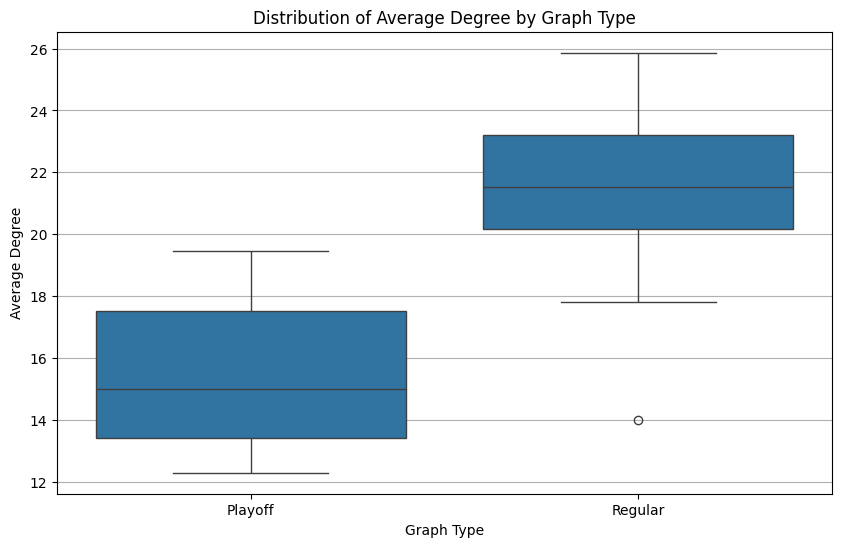

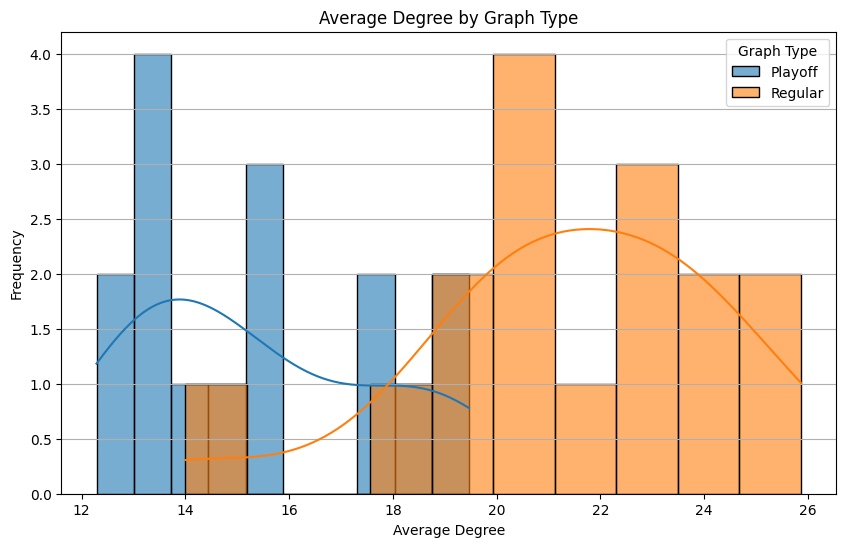

In [72]:
# Extract relevant columns for visualization
avg_degree_data = stats_df[["Graph Type", "Degree Avg"]]

# Box plot for distribution comparison
plt.figure(figsize=(10, 6))
sns.boxplot(data=avg_degree_data, x="Graph Type", y="Degree Avg")
plt.title("Distribution of Average Degree by Graph Type")
plt.xlabel("Graph Type")
plt.ylabel("Average Degree")
plt.grid(axis='y')
plt.show()

# Histogram for each graph type
plt.figure(figsize=(10, 6))
for graph_type in avg_degree_data["Graph Type"].unique():
    subset = avg_degree_data[avg_degree_data["Graph Type"] == graph_type]
    sns.histplot(subset["Degree Avg"], kde=True, label=graph_type, bins=10, alpha=0.6)

plt.title("Average Degree by Graph Type")
plt.xlabel("Average Degree")
plt.ylabel("Frequency")
plt.legend(title="Graph Type")
plt.grid(axis='y')
plt.show()